<a href="https://colab.research.google.com/github/LizzieChall/huggingface_food_not_food_text_classification_demo/blob/main/huggingface_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Hugging Face Transformers.

Welcome to the Hugging Face Text Classification project!

We’re going to be bulding a `food/not_food` **text classification model.**

Given a piece of a text (such as an image caption), our model will be able to predict if it’s about food or not.

We’re going to start with a text dataset, build a model to classify text samples and then share our model as a demo others can use.

To do so, we’ll be using a handful of helpful open-source tools from the Hugging Face ecosystem.

We’re going to follow the workflow of:

1. Create and preprocess data.
2. Define the model we’d like to use with [transformers.AutoModelForSequenceClassification](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [transformers.TrainingArguments.](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [transformers.Trainer.](https://huggingface.co/docs/transformers/en/main_classes/trainer)
5. Train the model by calling [Trainer.train().](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train)
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

## Importing the necessary libraries.

We’ll need to install the following libraries from the Hugging Face ecosystem:

* Transformers - comes pre-installed on Google Colab.
* Datasets - a library for accessing and manipulating datasets on and off the Hugging Face Hub, we can install it via `pip install datasets`.
* Evaluate - a library for evaluating machine learning model performance with various metrics, we can install it via `pip install evaluate`.
* Accelerate - a library for training machine learning models faster, we can install it via `pip install accelerate`.
* Gradio - a library for creating interactive demos of machine learning models, we can install it via `pip install gradio`.

In [ ]:
# Install dependencies
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate, gradio
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using accelerate version: {accelerate.__version__}")


Using transformers version: 4.56.1
Using torch version: 2.8.0+cu126
Using datasets version: 4.1.1
Using accelerate version: 1.10.1


## Getting a dataset

Building food / not food text classification model: need food / not food text dataset.



In [ ]:
from datasets import load_dataset

dataset = load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [ ]:
# what features are there?
dataset.column_names

{'train': ['text', 'label']}

In [ ]:
# Access the training split
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [ ]:
dataset["train"][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

### Inspect random samples

In [ ]:
import random

random_indexes = random.sample(range(len(dataset["train"])), 5)
print(random_indexes)

random_samples = dataset["train"][random_indexes]

print(f"[INFO] Random samples from dataset:\n")
for text, label in zip(random_samples["text"], random_samples["label"]):
  print(f"Text: {text} | Label: {label}")

[6, 189, 70, 62, 57]
[INFO] Random samples from dataset:

Text: Pair of reading glasses left open on a book | Label: not_food
Text: Set of board games stacked on a shelf | Label: not_food
Text: Two handfuls of bananas in a fruit bowl with grapes on the side, the fruit bowl is blue | Label: food
Text: Computer desk with laptop and computer monitor on it with a mousepad and keyboard | Label: not_food
Text: Vegetarian sushi roll with avocado and pickled radish filling. | Label: food


In [ ]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [ ]:
# Check the count of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

In [ ]:
# Turn our dataset into a dataframe and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
142,A slice of pizza with a generous amount of shr...,food
6,Pair of reading glasses left open on a book,not_food
97,Telescope positioned on a balcony,not_food
60,A close-up of a family playing a board game wi...,not_food
112,Rich and spicy lamb rogan josh with yogurt gar...,food
181,"A steaming bowl of fiery chicken curry, infuse...",food
197,"Pizza with a stuffed crust, oozing with cheese",food


In [ ]:
food_not_food_df["label"].value_counts()

,count
label,
food,125
not_food,125


## Preparing data for text classification

We’ve got our data ready but there are a few steps we’ll need to take before we can model it.

The main two being:

1. **Tokenization** - turning our text into a numerical representation (machines prefer numbers rather than words), for example, {"a": 0, "b": 1, "c": 2...}.
2. **Creating a train/test split** - right now our data is in a training split only but we’ll create a test set to evaluate our model’s performance.

In [ ]:
# Create a mapping for labels to numeric value
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [ ]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])}
label2id = {label: idx for idx, label in id2label.items()}
print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [ ]:
id2label = {}
for idx, label in enumerate(dataset["train"].unique("label")[::-1]):
  print(idx, label)
  id2label[idx] = label

0 not_food
1 food


In [ ]:
# Turn labels into 0 or 1
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favorite food: pizza", "label": "food"}

# Test our function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favorite food: pizza', 'label': 1}

In [ ]:
# Map our dataset labels to numbers (the whole dataset)
# We do this with dataset.map()
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [ ]:
# Shuffle data and look at 5 more random samples
dataset.shuffle()[:5]

{'text': ['Set of oven mitts hanging on a hook',
  'Set of cookie cutters collected in a jar',
  'Pizza with a dessert twist, featuring a sweet Nutella base and fresh strawberries on top',
  'Set of binoculars placed on a table',
  'Two handfuls of bananas in a fruit bowl with grapes on the side, the fruit bowl is blue'],
 'label': [0, 0, 1, 0, 1]}

## Split the dataset into training and test sets

* Train set - the model will learn patterns on this dataset.

* Validation set (optional) - we can tune our model's hyperparameters on this set (because we are using a small dataset we can leave this out and just have a train and a test set).

* Test set - the model will evaluate patterns on this dataset.

We can split our dataset using `datasets.Dataset.train_test_split()`

In [ ]:
# Split our dataset in train/test/split
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [ ]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]
random_sample_train

{'text': 'Decadent butter chicken curry, featuring tender chicken in a velvety sauce made with butter and tomatoes, served with warm naan bread.',
 'label': 1}

In [ ]:
random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]
random_sample_test

{'text': 'Pizza with a dessert twist, featuring a sweet Nutella base and fresh strawberries on top',
 'label': 1}

### Tokenizing text data (turning text into numbers)

The premise of tokenization is to turn words into numbers.

For example: "I love ice cream" -> [40, 150, 789, 500]

_

The transformers library has in-built support for HuggingFace `Tokenizers`.

And the class `transformers.AutoTokenizer` helps pair a model to a tokenizer.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Test out the tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

* `input_ids` = our text turned into numbers. [CLS, I, love, pizza, SEP]
* `attention_mask` = whether or not to pay attention to certain tokens (1 = yes pay attention, 0 = no, don't pay attention)

In [ ]:
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
# Get the length of our tokenizer vocab
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"[INFO]: Number of items in our tokenizer vocab: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"[INFO] Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

[INFO]: Number of items in our tokenizer vocab: 30522
[INFO] Max tokenizer input sequence length: 512


In [ ]:
# Does "Elizabeth" occur in the vocab?
tokenizer.vocab["hello"]

7592

In [ ]:
tokenizer("Elizabeth")

{'input_ids': [101, 3870, 102], 'attention_mask': [1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer("Elizabeth").input_ids)

['[CLS]', 'elizabeth', '[SEP]']

In [ ]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("😊").input_ids)

['[CLS]', '[UNK]', '[SEP]']

In [ ]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [ ]:
import random
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('##pm', 9737),
 ('persona', 16115),
 ('rhythm', 6348),
 ('winfield', 24739),
 ('internship', 22676)]

### Making a preprocessing function to tokenize text.

We want to make it easy to go from sample to tokenized_sample.


In [ ]:
def tokenize_text(examples):
  """
  Tokenize given example text and return the tokenized text.
  """
  return tokenizer(examples["text"],
                   padding=True,
                   truncation=True)

In [ ]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
long_text = "I love pizza " * 1000
len(long_text)

13000

In [ ]:
tokenized_long_text = tokenize_text({"text": long_text, "label": 1})
len(tokenized_long_text["input_ids"])

512

In [ ]:
# Map our tokenized text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [ ]:
# Get two samples from the tokenized datasets
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
  print(f"[INFO] Key: {key}")
  print(f"Train Sample: {train_tokenized_sample[key]}")
  print(f"Test Sample: {test_tokenized_sample[key]}")
  print()

[INFO] Key: text
Train Sample: Set of headphones placed on a desk
Test Sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train Sample: 0
Test Sample: 1

[INFO] Key: input_ids
Train Sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test Sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train Sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test Sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Tokenization takeaways

1. Tokenizers = turn data into numbers (e.g. text -> map to number)
2. Many models are out there and have different tokenizers, HuggingFace's `Auto` (e.g. `AutoTokenizer`, `AutoProcessor`, `AutoModel`, etc help to match tokenizers to models)
3. Tokenizers can happen in parallel using `map` and `batched` functions.

## Setting up an evaluation metric.

We want to use the evaluation metric to get a numerical idea of how our model is performing.

Some common evaluation metrics for classification are:
* Accuracy (how many examples out of 100 did you get correct?)
* Precision
* Recall
* F1 Score

Evaluation metric is important because some projects may have an evaluation threshold to fulfill.


E.g. May require 98%+ test accuracy to be commercially viable.

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
# Example predictions and accuracy score
example_preds_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_preds_one_incorrect = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels))}")
print(f"Accuracy when one prediction is incorrect: {compute_accuracy((example_preds_one_incorrect, example_labels))}")


Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is incorrect: {'accuracy': 0.9}


## Setting up a model for training.

* We're going to be using transfer learning.
* Transfer learning is a powerful technique, unique to deep learning models, that enables us to use the patterns one model has learned on another problem for our own problem.


Workflow for training:
1. Create and preprocess data ✅
2. Define the model we'd like to use for our problem (in our case it will be the `distilbert/distilbert-base-uncased` model found here:   https://huggingface.co/distilbert/distilbert-base-uncased)
3. Define training arguments for training our model using `transformers.TrainingArguments`
4. Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model (to our local machine or to the HuggingFace Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Our model is comprised of the following parts:

1. `Embeddings` - embeddings are a form of learned representation of tokens. So if tokens are a direct mapping from token to number, embeddings are a learned vector representation.
2. `Transformer` - our model architecture backbone, this has discovered patterns/relationships in the embeddings.
3. `Classifier` - we need to customize this layer to suit our problem.

### Counting the parameters of our model.

Weights/parameters = small numeric opportunities for a model to learn patterns in data.

In [ ]:
def count_params(model):
  """
  Count the parameters of a PyTorch model.
  """
  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())

  return {"trainable_parameters": trainable_parameters,
          "total_parameters": total_parameters}

count_params(model)


{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Looks like our model has 67M parameters and **all** of them are trainable.

* Generally, the more parameters a model has, the more capacity it has to learn.
* For the best possible performance, more parameters is better (generally).
  - However, more parameters requires more compute and time.
  - A smaller model with specific data can perfrom just as well.

### Create a folder or directory for saving models



In [ ]:
# Create model output directory
from pathlib import Path

# Create models dir
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "food_not_food_distilbert-base-uncased_text_classification_model"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/food_not_food_distilbert-base-uncased_text_classification_model')

### Setting up hyperparameters with TrainingArguments

Workflow for training:
1. ✅ Create and preprocess data
2. ✅ Define the model we'd like to use for our problem (in our case it will be the `distilbert/distilbert-base-uncased` model found here:   https://huggingface.co/distilbert/distilbert-base-uncased)
3. Define training arguments for training our model using `transformers.TrainingArguments`

   - These are also known as "hyperparameters" = settings on your model that you can adjust
   - Parameters = weightes/patterns in the model that get updated automatically

4. Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model (to our local machine or to the HuggingFace Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo

In [ ]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

BATCH_SIZE = 32

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    hub_private_repo=False,
)

[INFO] Saving model checkpoints to: models/food_not_food_distilbert-base-uncased_text_classification_model


In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

### Setting up an instance of Trainer

Workflow for training:
1. ✅ Create and preprocess data
2. ✅ Define the model we'd like to use for our problem (in our case it will be the `distilbert/distilbert-base-uncased` model found here:   https://huggingface.co/distilbert/distilbert-base-uncased)
3. ✅ Define training arguments for training our model using `transformers.TrainingArguments`

   - These are also known as "hyperparameters" = settings on your model that you can adjust
   - Parameters = weightes/patterns in the model that get updated automatically

4. Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model (to our local machine or to the HuggingFace Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import Trainer

# Setup Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

trainer

/tmp/ipython-input-247060917.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train the model by calling `Trainer.train`

Workflow for training:
1. ✅ Create and preprocess data
2. ✅ Define the model we'd like to use for our problem (in our case it will be the `distilbert/distilbert-base-uncased` model found here:   https://huggingface.co/distilbert/distilbert-base-uncased)
3. ✅ Define training arguments for training our model using `transformers.TrainingArguments`

   - These are also known as "hyperparameters" = settings on your model that you can adjust
   - Parameters = weightes/patterns in the model that get updated automatically

4. ✅ Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model (to our local machine or to the HuggingFace Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo

In [ ]:
input_predictions = np.array([[-1.5652031, 1.4852538 ]])
input_references = np.array([0])

# Need to get the maximum value from the model output (the index) as this is the most likely label according to the model
if len(input_predictions.shape) >= 2:
    input_predictions = np.argmax(input_predictions, axis=1)

input_predictions

array([1])

In [ ]:
compute_accuracy(predictions_and_labels=(input_predictions, input_references))

{'accuracy': 0.0}

In [ ]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.338800,0.041322,1.000000
2,0.019300,0.005754,1.000000
3,0.003700,0.002047,1.000000
4,0.001700,0.001152,1.000000
5,0.001000,0.000819,1.000000
6,0.000800,0.000670,1.000000
7,0.000700,0.000593,1.000000
8,0.000600,0.000550,1.000000
9,0.000600,0.000528,1.000000
10,0.000600,0.000520,1.000000


In [ ]:
# Inspect training metrics
for key, value in results.metrics.items():
  print(f"{key} : {value}")

train_runtime : 240.2006
train_samples_per_second : 8.326
train_steps_per_second : 0.291
total_flos : 18110777160000.0
train_loss : 0.03679406267058637
epoch : 10.0


### Save the model for later use



In [ ]:
# Save model
print(f"Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

Saving model to models/food_not_food_distilbert-base-uncased_text_classification_model


### Inspect the model training metrics

In [ ]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# View the first 3
trainer_history_metrics[:3]

[{'loss': 0.3388,
  'grad_norm': 0.9611281752586365,
  'learning_rate': 9.142857142857143e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.04132193699479103,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0532,
  'eval_samples_per_second': 940.111,
  'eval_steps_per_second': 37.604,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0193,
  'grad_norm': 0.09880883246660233,
  'learning_rate': 8.142857142857143e-05,
  'epoch': 2.0,
  'step': 14}]

In [ ]:
import pprint

# Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through our metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# View the first from each
print(f"First two in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\nFirst two in eval epochs:")
pprint.pprint(trainer_history_eval_set[:2])

First two in training set:
[{'epoch': 1.0,
  'grad_norm': 0.9611281752586365,
  'learning_rate': 9.142857142857143e-05,
  'loss': 0.3388,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.09880883246660233,
  'learning_rate': 8.142857142857143e-05,
  'loss': 0.0193,
  'step': 14}]

First two in eval epochs:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.04132193699479103,
  'eval_runtime': 0.0532,
  'eval_samples_per_second': 940.111,
  'eval_steps_per_second': 37.604,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.0057538952678442,
  'eval_runtime': 0.0527,
  'eval_samples_per_second': 948.577,
  'eval_steps_per_second': 37.943,
  'step': 14}]


### Taking a look at the loss curves

Loss curves are a good visualization of your model's performance over time, and ideally will trend downwards.

In [ ]:
# Create a pandas DataFrame for the training and evaluation metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_train_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.3388,0.961128,0.000091,1.0,7
1,0.0193,0.098809,0.000081,2.0,14
2,0.0037,0.039035,0.000071,3.0,21
3,0.0017,0.025938,0.000061,4.0,28
4,0.0010,0.013744,0.000051,5.0,35


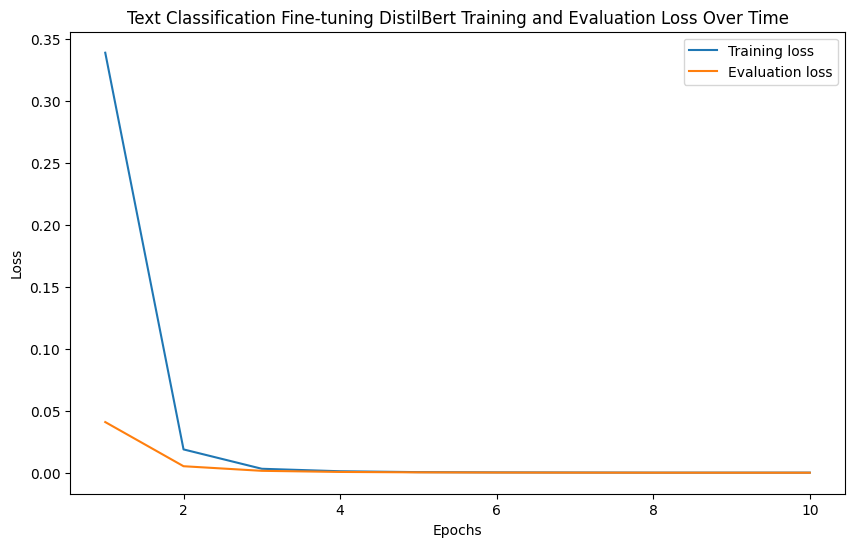

In [ ]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_train_df["epoch"], trainer_history_train_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Text Classification Fine-tuning DistilBert Training and Evaluation Loss Over Time")
plt.legend()
plt.show()

### Pushing our model to the HuggingFace Hub

Reasons for doing this:

* We can share our model.
* Other people can try it out.
* We can keep a history of different model versions.

To write to HuggingFace:
- If on Google Colab: setup "token" with "read and write" access.
- If on local machine: setup `huggingface-cli` (https://huggingface.co/docs/huggingface_hub/en/guides/cli)

To save to the HuggingFace Hub we are going to use the `Trainer.push_to_hub` method.

In [ ]:
# Log in to Hugging Face from Notebook
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Save our model to the HuggingFace Hub
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model"
)

print(f"Model successfully uploaded to the HuggingFace Hub with URL: {model_upload_url}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...n_model/model.safetensors:  12%|#2        | 33.1MB /  268MB            

  ...n_model/training_args.bin:  21%|##        | 1.23kB / 5.84kB            

Model successfully uploaded to the HuggingFace Hub with URL: https://huggingface.co/LizzChall/food_not_food_distilbert-base-uncased_text_classification_model/tree/main/


### Making and evaluating predictions on the test data.

Workflow for training:
1. ✅ Create and preprocess data
2. ✅ Define the model we'd like to use for our problem (in our case it will be the `distilbert/distilbert-base-uncased` model found here:   https://huggingface.co/distilbert/distilbert-base-uncased)
3. ✅ Define training arguments for training our model using `transformers.TrainingArguments`

   - These are also known as "hyperparameters" = settings on your model that you can adjust
   - Parameters = weightes/patterns in the model that get updated automatically

4. ✅ Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. ✅ Train the model by calling `Trainer.train()`
6. ✅ Save the model (to our local machine or to the HuggingFace Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo




In [ ]:
# Perform predictions on the test data
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0005204931367188692,
 'test_accuracy': 1.0,
 'test_runtime': 0.0946,
 'test_samples_per_second': 528.493,
 'test_steps_per_second': 21.14}

In [ ]:
predictions_all

PredictionOutput(predictions=array([[-3.4188225,  4.0324287],
       [ 4.1835074, -3.7533395],
       [-3.4261076,  4.0251036],
       [ 4.2181334, -3.7787805],
       [ 4.2271934, -3.7474325],
       [-3.4285955,  4.0277967],
       [ 4.2261305, -3.753712 ],
       [ 4.234221 , -3.7631276],
       [-3.4254518,  4.026401 ],
       [-3.42516  ,  4.0130377],
       [-3.4310143,  4.0220895],
       [-3.4049966,  4.0195637],
       [ 4.1876826, -3.7551675],
       [-3.4298651,  4.014366 ],
       [-3.4137225,  4.0263824],
       [ 4.214499 , -3.7714398],
       [-3.429452 ,  4.01207  ],
       [ 4.1296854, -3.7415898],
       [-3.4246876,  4.0210347],
       [-3.4265065,  4.02121  ],
       [-3.4260614,  4.0203404],
       [-3.4294672,  4.0184956],
       [ 4.2191544, -3.7405367],
       [ 4.1991205, -3.7737446],
       [-3.4314303,  4.016989 ],
       [-3.4277613,  4.0272956],
       [-3.420276 ,  4.013641 ],
       [ 4.1938214, -3.7465665],
       [-3.4277837,  4.026138 ],
       [ 4.201

### Let's get predicted probabilities and evaluate by hand

Turning the predicted logits(raw output of the model) to predictions probabilities with torch.softmax then to predicted labels for readability.



In [ ]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities with torch.softmax
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = tokenized_dataset["test"] ["label"]

# 4. Compute prediction labels to true labels and get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}")

[INFO] Test accuracy: 100.0


### Exploring our model's prediction probabilities.

It's a very good way to evaluate a model by sorting predictions by prediction probabilities and seeing where the model went wrong.

In [ ]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999420
1,Red brick fireplace with a mantel serving as a...,0,0,0.999643
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999420
3,Set of mugs hanging on a hook,0,0,0.999664
4,Standing floor lamp providing light next to an...,0,0,0.999656


In [ ]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
43,Set of muffin tins stacked together,0,0,0.998798
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999400
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999404
26,A fruit platter with a variety of exotic fruit...,1,1,0.999409
9,Cherry tomatoes and mozzarella balls in a bowl...,1,1,0.999412
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.999412
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999413
46,A bowl of sliced kiwi with a sprinkle of sugar...,1,1,0.999413
16,"Zucchini in a bowl, sprinkled with basil and s...",1,1,0.999414
31,Crunchy sushi roll with tempura flakes or pank...,1,1,0.999414


### Making and inspecting predictions on custom data.

Two main ways to perform inference:
1. **Pipeline Mode** - Using `transformers.pipeline` to load our model and perform text classification.
2. **PyTorch Mode** - Using a combination of `transformers.AutoTokenizer` and `transformers.AutoModelForSequenceClassification` and passing each our target model name.

Each mode supports:

1. Predictions one at a time (fast but can be slower with many many samples).
2. Batches of predictions at a time(faster but up to a point, depends on the batch size).

In [ ]:
# Setup our device for making predictions

def set_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
  return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


### Making predictions with pipeline mode.

In [ ]:
local_model_path = "models/food_not_food_distilbert-base-uncased_text_classification_model"

huggingface_model_path = "LizzChall/food_not_food_distilbert-base-uncased_text_classification_model"

In [ ]:
import torch
from transformers import pipeline

# Set the batch size
BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model= local_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier

Device set to use cuda


In [ ]:
test_not_food_sentence = "Text to test the pipeline mode."
food_not_food_classifier(test_not_food_sentence)

[[{'label': 'not_food', 'score': 0.9995489716529846}]]

In [ ]:
test_custom_sentence = "For breakfast I had waffles, sausages, and eggs."
food_not_food_classifier(test_custom_sentence)

[[{'label': 'food', 'score': 0.9993822574615479}]]

In [ ]:
del food_not_food_classifier

In [ ]:
# Use pipeline with a model from Hugging Face
food_not_food_classifier = pipeline(task="text-classification",
                                    model=huggingface_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier(test_not_food_sentence)

Device set to use cuda


[[{'label': 'not_food', 'score': 0.9995489716529846}]]

### Making multiple predictions at the same time with batch predictions.

In [ ]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9983888864517212}],
 [{'label': 'not_food', 'score': 0.9993321299552917}],
 [{'label': 'not_food', 'score': 0.9987264275550842}],
 [{'label': 'not_food', 'score': 0.99951171875}],
 [{'label': 'not_food', 'score': 0.9994196891784668}],
 [{'label': 'not_food', 'score': 0.9994412064552307}],
 [{'label': 'not_food', 'score': 0.9991315007209778}],
 [{'label': 'food', 'score': 0.9993730187416077}],
 [{'label': 'food', 'score': 0.9985628724098206}]]

In [ ]:
food_captions = [
    "A steaming plate of pad thai, garnished with fresh lime wedges.",
    "The aroma of freshly baked croissants wafted through the air.",
    "Savoring the flavors of a traditional Indian curry.",
    "A juicy burger and crispy fries on a sunny summer day.",
    "Fresh sushi rolls, expertly crafted with love and care.",
    "The sweet scent of ripe strawberries filled the room.",
    "A warm, gooey cookie straight from the oven.",
    "The art of making pasta from scratch, a labor of love.",
    "A decadent chocolate cake, perfect for special occasions.",
    "The vibrant colors of a fruit salad, a feast for the eyes."
]

food_not_food_classifier(food_captions)

[[{'label': 'food', 'score': 0.9994107484817505}],
 [{'label': 'food', 'score': 0.9993402361869812}],
 [{'label': 'food', 'score': 0.9994082450866699}],
 [{'label': 'food', 'score': 0.9993957281112671}],
 [{'label': 'food', 'score': 0.9993698000907898}],
 [{'label': 'food', 'score': 0.9993522763252258}],
 [{'label': 'food', 'score': 0.9990948438644409}],
 [{'label': 'food', 'score': 0.9983200430870056}],
 [{'label': 'food', 'score': 0.9993962049484253}],
 [{'label': 'food', 'score': 0.999403715133667}]]

In [ ]:
not_food_captions = [
    "A beautiful sunset over the rolling hills of Tuscany.",
    "The sound of waves crashing against the shore, soothing the soul.",
    "A stunning work of art, created with passion and precision.",
    "The majestic beauty of a mountain range, inspiring awe.",
    "A cozy living room, filled with warmth and comfort.",
    "The intricate details of a handmade clock, a testament to craftsmanship.",
    "A serene forest, teeming with life and tranquility.",
    "The vibrant lights of a city skyline, pulsating with energy.",
    "A breathtaking waterfall, a wonder of nature.",
    "The soft petals of a flower, delicate and lovely."
]

food_not_food_classifier(not_food_captions)

[[{'label': 'not_food', 'score': 0.9993268251419067}],
 [{'label': 'not_food', 'score': 0.9995966553688049}],
 [{'label': 'not_food', 'score': 0.9994754195213318}],
 [{'label': 'not_food', 'score': 0.99953293800354}],
 [{'label': 'not_food', 'score': 0.9996356964111328}],
 [{'label': 'not_food', 'score': 0.9996178150177002}],
 [{'label': 'not_food', 'score': 0.9995614886283875}],
 [{'label': 'not_food', 'score': 0.9995792508125305}],
 [{'label': 'not_food', 'score': 0.9995771050453186}],
 [{'label': 'food', 'score': 0.9991008043289185}]]

In [ ]:
confusing_captions = [
    "Bite into the weekend with a fresh start.",
    "The sauce of sarcasm dripped from her words.",
    "A pinch of salt in the wound made it hard to forgive.",
    "The recipe for success involves hard work and dedication.",
    "A taste of freedom was exhilarating, but short-lived.",
    "The flavors of nostalgia washed over me as I flipped through old photos.",
    "A dash of drama was added to the meeting with the CEO's announcement.",
    "The bitter truth was hard to swallow.",
    "A spoonful of sugar helps the medicine go down, but not in this case.",
    "The aroma of opportunity filled the air at the career fair."
]

food_not_food_classifier(confusing_captions)

[[{'label': 'not_food', 'score': 0.9579307436943054}],
 [{'label': 'not_food', 'score': 0.9990371465682983}],
 [{'label': 'food', 'score': 0.9991015195846558}],
 [{'label': 'not_food', 'score': 0.9992483258247375}],
 [{'label': 'not_food', 'score': 0.999452531337738}],
 [{'label': 'not_food', 'score': 0.999397873878479}],
 [{'label': 'not_food', 'score': 0.9994565844535828}],
 [{'label': 'not_food', 'score': 0.9992189407348633}],
 [{'label': 'food', 'score': 0.9992615580558777}],
 [{'label': 'not_food', 'score': 0.9995504021644592}]]

### Time our model across larger sample sizes.

In [ ]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 112

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
  # Make a prediction
  food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

total_time_one_at_a_time = end_time_one_at_a_time - start_time_one_at_a_time
avg_time_per_pred = total_time_one_at_a_time / len(sentences_1000)
print(f"[INFO]: Total time for making predictions on {len(sentences_1000)} samples one at a time: {total_time_one_at_a_time}s")
print(f"[INFO] Average time per predictions one at a time: {avg_time_per_pred}s")

[INFO] Number of sentences: 1008
[INFO]: Total time for making predictions on 1008 samples one at a time: 4.658188581466675s
[INFO] Average time per predictions one at a time: 0.004621218830820114s


In [ ]:
# Let's now use batches
for i in [10, 100, 1000, 10000]:
  sentences_big = sentences * i
  print(f"[INFO] Number of sentences: {len(sentences_big)}")

  start_time_batches = time.time()
  food_not_food_classifier(sentences_big)
  end_time_batches = time.time()

  total_time_per_all_sentences_batch_mode = end_time_batches - start_time_batches
  avg_time_per_pred_batch_mode = total_time_per_all_sentences_batch_mode / len(sentences_big)

  print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(total_time_per_all_sentences_batch_mode, 6)}s")
  print(f"[INFO] Average inference time per sentence: {round(avg_time_per_pred_batch_mode, 8)}s")
  print()

[INFO] Number of sentences: 90
[INFO] Inference time for 90 sentences: 0.075491s
[INFO] Average inference time per sentence: 0.00083879s

[INFO] Number of sentences: 900
[INFO] Inference time for 900 sentences: 0.739987s
[INFO] Average inference time per sentence: 0.00082221s

[INFO] Number of sentences: 9000
[INFO] Inference time for 9000 sentences: 7.757358s
[INFO] Average inference time per sentence: 0.00086193s

[INFO] Number of sentences: 90000
[INFO] Inference time for 90000 sentences: 78.385847s
[INFO] Average inference time per sentence: 0.00087095s



### Making predictions with PyTorch.

Steps with PyTorch predictions:

1. Create the tokenizer with `AutoTokenizer`
2. Create the model with `AutoModel` (AutoModelForSequenceClassification)
3. Tokenize text with 1
4. Make predictions with 2
5. Format predictions

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Setup the model path
model_path = "models/food_not_food_distilbert-base-uncased_text_classification_model"

# Create an example to predict on
sample_food_text = "A delicious photo of a plate of cream cheese, topped with whipped cream and strawberries."

# Create an instance of AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_food_text,
                   return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997,  6949,  8808,
          1010,  9370,  2007, 12428,  6949,  1998, 13137, 20968,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load our  text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

In [ ]:
import tensorflow as tf

model.eval()

with torch.inference_mode():
  outputs = model(**inputs)
  print(f"[INFO] Outputs: {outputs}")

[INFO] Outputs: SequenceClassifierOutput(loss=None, logits=tensor([[-3.4272,  4.0245]]), hidden_states=None, attentions=None)


In [ ]:
# Convert logits to prediction probability plus label
predicted_class_id = outputs.logits.argmax().item()
predicted_prob = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_food_text}")
print(f"[INFO] Predicted class label: {model.config.id2label[predicted_class_id]}")
print(f"[INFO] Predicted class probability: {predicted_prob}")

Text: A delicious photo of a plate of cream cheese, topped with whipped cream and strawberries.
[INFO] Predicted class label: food
[INFO] Predicted class probability: 0.9994199275970459


In [ ]:
food_not_food_classifier(sample_food_text)

[[{'label': 'food', 'score': 0.9994199275970459}]]

### Putting it all together.

End-to-end from data import to model evaluation to model saving for our text classification project.

In [ ]:
# 1. Import necessary packages
import pprint
from pathlib import Path

import numpy as np
import torch

import datasets
import evaluate

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#2. Setup variables for model training and saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/food_not_food_text_classifier_distilbert-base-uncased"

# 3. Create a directory for saving models
print(f"[INFO] Creating directory for saving models: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(DATASET_NAME)

# Create mappings from id2label and label2id (adjust these for your target dataset, can also create these programmatically)
id2labe = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food":1}

# Create function to map IDs to labels in dataset
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

# Map preprocessing function to dataset
dataset = dataset["train"].map(map_labels_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Import a tokenizer and map it to our dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast=True)

# Create a preprocessing function to tokenize text samples
def tokenize_text(examples):
  return tokenizer(examples["text"],
                   padding=True,
                   truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

# 6. Set up an evaluation metric & function to evaluate our model
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels):
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

# 7. Import a model and prepare it for training
print(f"[INFO] Loading model: {MODEL_NAME}")

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
print(f"[INFO] Model loading complete!")

# Setup TrainingArguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    hub_private_repo=False
)

# Create Trainer instance and train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy

)

# 8. Train the model on our text dataset
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Save the trained model (note: this will overwrite our previous model)
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model (putting it all together)"
)
print(f"[INFO] Model upload complete, model available at: {model_upload_url}")

# 11. Evaluate the model on the test data
print(f"[INFO] Performing evaluation on test dataset...")

predictions_all = trainer.predict(tokenized_dataset["test"])
predictions_values = predictions_all.predictions
predictions_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
pprint.pprint(predictions_metrics)


[INFO] Creating directory for saving models: models/food_not_food_text_classifier_distilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: mrdbourke/learn_hf_food_not_food_image_captions
[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased
[INFO] Loading model: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1701595809.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[INFO] Model loading complete!
[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.338800,0.041322,1.000000
2,0.019300,0.005754,1.000000
3,0.003700,0.002047,1.000000
4,0.001700,0.001152,1.000000
5,0.001000,0.000819,1.000000
6,0.000800,0.000670,1.000000
7,0.000700,0.000593,1.000000
8,0.000600,0.000550,1.000000
9,0.000600,0.000528,1.000000
10,0.000600,0.000520,1.000000


[INFO] Model training complete, saving model to local path: models/food_not_food_text_classifier_distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...uncased/model.safetensors:  12%|#2        | 33.1MB /  268MB            

  ...uncased/training_args.bin:  30%|##9       | 1.74kB / 5.84kB            

[INFO] Model upload complete, model available at: https://huggingface.co/LizzChall/food_not_food_text_classifier_distilbert-base-uncased/tree/main/
[INFO] Performing evaluation on test dataset...


[INFO] Prediction metrics on the test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0005204931367188692,
 'test_runtime': 0.0907,
 'test_samples_per_second': 551.364,
 'test_steps_per_second': 22.055}


In [ ]:
# 12. Testing the model on a custom sample to make certain that it works
from transformers import pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model= model_save_dir,
                                    device=torch.device("cuda") if torch.cuda.is_available() else torch.ddevice("cpu"),
                                    top_k=1,
                                    batch_size=32)

custom_sample = "A delicious photo of a plate of cream cheese, topped with whipped cream and strawberries."
print(f"[INFO] Testing the model on a custom sample...")

food_not_food_classifier(custom_sample)

Device set to use cuda


[INFO] Testing the model on a custom sample...


[[{'label': 'food', 'score': 0.9994199275970459}]]

### Turning our model into a demo.

We're going to create a machine learning demo using Gradio.

Workflow:
1. ✅ Create and preprocess data
2. ✅ Define the model we'd like to use for our problem (in our case it will be the `distilbert/distilbert-base-uncased` model found here:   https://huggingface.co/distilbert/distilbert-base-uncased)
3. ✅ Define training arguments for training our model using `transformers.TrainingArguments`

   - These are also known as "hyperparameters" = settings on your model that you can adjust
   - Parameters = weightes/patterns in the model that get updated automatically

4. ✅ Pass `TrainingArguments` to an instance of `transformers.Trainer`
5. ✅ Train the model by calling `Trainer.train()`
6. ✅ Save the model (to our local machine or to the HuggingFace Hub)
7. ✅ Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo

### Creating a function to perform inference.

1. Take an input of string.
2. Setup a text classification pipeline.
3. Get the output from the pipeline.
4. Return the output from the pipeline in step 3 as a formatted dictionary with the format:
`{"label_1": probability_1, "label_2": probability_2}`

In [ ]:
from typing import Dict

# 1. Create a function which takes text as input
def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """

    # 2. Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task="text-classification",
                                        model=local_model_path,
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu", # set the device to work in any environment
                                        top_k=None) # return all possible scores (not just top-1)

    # 3. Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # 4. Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# Test out the function
food_not_food_classifier("My lunch today was chicken and salad")

Device set to use cuda


{'food': 0.9991205334663391, 'not_food': 0.0008794725290499628}

### Building a small Gradio demo to run locally.

In [ ]:
# Import Gradio
import gradio as gr

# Create a gradio interface
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title="Food Not Food Classifier",
    description="A text classifier to determine if a sentence or text is about food or not.",
    examples=[
        ["I'm craving a juicy burger and crispy fries right now!"],
        ["The new smartphone features an impressive camera and sleek design."]
    ]
)

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3c54e73b44ff796842.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Making our demo publicly accessible.

There are two main ways to make our demo pubicly accessible with Hugging Face Spaces:

1. Manually - We can go to huggingface.co/spaces -> "Create new space" -> add our files and publish!
2. Programmatically - We can use the Hugging Face Hub Python API and add our files to a Space with code.

We're going to create these three files to create a Space programmatically:
1. `app.py` - This is the main app with functionality of our demo.
2. `requirements.txt` - These are the dependencies which our app will require.
3. `README.md` - This will explain what the project/demo is about.

We'll create these files with the following file structure:

```
demos/
└── food_not_food_text_classifier/
    ├── app.py
    ├── README.md
    └── requirements.txt
```


### Making a directory to store our demo.

In [ ]:
from pathlib import Path

# Make directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifier demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

### Making an app.py file.

In the `app.py` file we are going to:
1. Import packages.
2. Define our function to use our model (this will work with Grdio).
3. Create a demo with Gradio.
4. Run the demo with `demo.launch()`.

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/app.py
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# Define our function to use with our model
def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """

    # Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task="text-classification",
                                        model="LizzChall/food_not_food_text_classifier_distilbert-base-uncased",
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu", # set the device to work in any environment
                                        top_k=None) # return all possible scores (not just top-1)

    # Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# 3. Create a Gradio interface with details about our app
description = """
A text classifier to determine if a sentence is about food or not food.

Fine-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) on a [small dataset of food and not food text](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

See [source code](https://github.com/LizzieChall/huggingface_food_not_food_text_classification_demo/blob/main/huggingface_text_classification.ipynb).
"""

demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title="🥑🚫🍗Food Not Food Classifier",
    description=description,
    examples=[
        ["I'm craving a juicy burger and crispy fries right now!"],
        ["The new smartphone features an impressive camera and sleek design."]
    ]
)

# 4. Launch the interface
if __name__ == "__main__":
  demo.launch()

Overwriting ../demos/food_not_food_text_classifier/app.py


### Making a README file.

This file is in markdown format, with a special YAML block at the top.

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/README.md

---
title: Food Not Food Text Classifier
emoji: 🥑🚫🍗
colorFrom: pink
colorTo: blue
sdk: gradio
sdk_version: 5.47.2
app_file: app.py
pinned: true
license: apache-2.0
---

# 🥑🚫🍗 Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions.](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

[Source code notebook](https://github.com/LizzieChall/huggingface_food_not_food_text_classification_demo/blob/main/huggingface_text_classification.ipynb).


Overwriting ../demos/food_not_food_text_classifier/README.md


### Making a requirements file.

This file is going to tell our Hugging Face Space which versions/ which packages to use.

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Overwriting ../demos/food_not_food_text_classifier/requirements.txt


### Uploading our demo to Hugging Face Spaces.

We will be using the Hugging Face Hub Python API.

To get our demo hosted on Hugging Face Spaces we’ll go through the following steps:

1. Import the required methods from the `huggingface_hub` package, including create_repo, get_full_repo_name, upload_file (optional, we’ll be using upload_folder) and upload_folder.
2. Define the demo folder we’d like to upload as well as the different parameters for the Hugging Face Space such as repo type ("space"), our target Space name, the target Space SDK ("gradio"), our Hugging Face token with write access (optional if it already isn’t setup).
3. Create a repository on Hugging Face Spaces using the `huggingface_hub.create_repo` method and filling out the appropriate parameters.
4. Get the full name of our created repository using the `huggingface_hub.get_full_repo_name` method.
5. Upload the contents of our target demo folder (../demos/food_not_food_text_classifier/) to Hugging Face Hub with `huggingface_hub.upload_folder`.
6. Hope it all works and inspect the results! 🤞



In [ ]:
# 1. Import the required methods for uploading to the HF Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)

# 2. Define the parameters we'd like to use for uploading our space
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "../demos/food_not_food_text_classifier"
HF_TARGET_SPACE_NAME = "food_not_food_text_classifier_demo"
HF_REPO_TYPE = "space"
HF_SPACE_SDK = "gradio"

# 3. Create a Space Repo on Hugging Face Hub
print(f"[INFO] Creating Space repository on Hugging Face Hub...")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    repo_type=HF_REPO_TYPE,
    private=False,
    space_sdk=HF_SPACE_SDK,
    exist_ok=True
)

# 4. Get the full repo name
hf_full_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {hf_full_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {hf_full_repo_name}")
folder_upload_url = upload_folder(
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    repo_id=hf_full_repo_name,
    repo_type=HF_REPO_TYPE,
    path_in_repo=".",
    commit_message="Uploading food not food text classifier demo from a notebook!"
)

print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating Space repository on Hugging Face Hub...
[INFO] Full Hugging Face Hub repo name: LizzChall/food_not_food_text_classifier_demo
[INFO] Uploading ../demos/food_not_food_text_classifier to repo: LizzChall/food_not_food_text_classifier_demo


No files have been modified since last commit. Skipping to prevent empty commit.


[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/LizzChall/food_not_food_text_classifier_demo/tree/main/.


### Embedding our Hugging Face Space

In [ ]:
from IPython.display import HTML

HTML(data='''
<iframe
	src="https://lizzchall-food-not-food-text-classifier-demo.hf.space"
	frameborder="0"
	width="850"
	height="450"
></iframe>
''')


### Saving a backup of notebook before cleaning the metadata to push to github. (just incase)

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/huggingface_text_classification.ipynb" \
   "/content/drive/MyDrive/Colab Notebooks/huggingface_text_classification_backup.ipynb"

### Cleaning Broken Widget Metadata from a Colab Notebook.

When commiting this notebook to GitHub we encountered a metadata error.

💡 Here is essentially a safe script to "strip out" the broken widget metadata so the notebook can open and render correctly.

1. Imports `nbformat` – a library to read and write Jupyter notebooks programmatically.

2. Specifies the notebook file path on your Google Drive.

3. Opens the notebook and loads its content into a Python object (nb).

4. Checks for metadata.widgets – this is the part of the notebook metadata causing rendering errors in Colab.

5. Removes `metadata.widgets` if it exists, or prints a message if it doesn’t.

6. Writes the cleaned notebook back to the same file, overwriting the old version.

7. Prints a confirmation once the notebook has been cleaned and saved.

In [ ]:
import nbformat

# Path to the notebook in Drive
notebook_path = "/content/drive/MyDrive/Colab Notebooks/huggingface_text_classification.ipynb"

# Load the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

# Clean out the problematic metadata
if "widgets" in nb.metadata:
    print("Found 'metadata.widgets' — removing it...")
    del nb.metadata["widgets"]
else:
    print("No 'metadata.widgets' found. Nothing to clean.")

# Save cleaned notebook back
with open(notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("Notebook metadata cleaned and saved ✅")

Found 'metadata.widgets' — removing it...
Notebook metadata cleaned and saved ✅
